# sumaryzacja tekstu

In [1]:
from google.colab import drive


drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!nvidia-smi

Mon Jan 26 16:40:22 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install "datasets<3.0.0"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.


In [ ]:
!pip install bert-extractive-summarizer

In [4]:
!pip install pytorch-ignite
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.8/343.8 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 30.2 MB/s eta 0:00:00


## importowanie datesetu

In [68]:
from datasets import load_dataset


ds = load_dataset("xsum", trust_remote_code=True)
ds= ds.filter(lambda example: len(example["document"]) < 1500)
split_result = ds["test"].train_test_split(test_size=2, seed=42)
shots = split_result["test"]
ds["test"] = split_result["train"]

Using the latest cached version of the dataset since xsum couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /root/.cache/huggingface/datasets/xsum/default/0.0.0/7d4d486c2f8ef850b1a11aead99b894ff3dd7da9 (last modified on Mon Jan 26 16:41:54 2026).


Filter:   0%|          | 0/204045 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11332 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11334 [00:00<?, ? examples/s]

In [6]:
print(ds)
print(shots)

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 32053
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 1746
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 1727
    })
})
Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 2
})


In [ ]:
from summarizer import Summarizer
model = Summarizer()

In [8]:
from ignite.metrics import Rouge

m = Rouge(variants=["L", 1], multiref="best")

candidate = "the cat is not there".split()
references = [
    "the cat is on the mat".split(),
    "there is a cat on the mat".split()
]

m.update(([candidate], [references]))

print(m.compute())

{'Rouge-L-P': 0.6, 'Rouge-L-R': 0.5, 'Rouge-L-F': 0.5, 'Rouge-1-P': 0.8, 'Rouge-1-R': 0.5714285714285714, 'Rouge-1-F': 0.5714285714285714}


In [40]:
num_workers = 1
batch_size = 10

In [41]:
from torch.utils.data import DataLoader
import torch
test_dataset = ds["test"].select(range(50))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
print(test_dataset)


Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 50
})


In [42]:
import string


def clean(text):
    if not text:
        return ["."]
    text = text.lower().translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )
    return text.split()


def rouge_score_loss(
    batch,
    model,
    bert: bool,
    tokenizer: any,
    prompt=None,
    promptsuff=None,
    m=Rouge(variants=["L", 2], multiref="best"),
):
    if bert:
        predictions = [
            model(doc, ratio=0.1) for doc in batch["document"]
        ]
    else:
        docs = [doc for doc in batch["document"]]

        prompted = [
            f"{prompt}{doc}{promptsuff}" for doc in batch["document"]
        ]
        print(prompted[0])
        inputs = tokenizer(
            prompted,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=4096,
        )

        device = next(model.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        summary_ids = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=50,
            do_sample=True,
            top_k=0,
            temperature=0.5,
        )

        input_length = inputs["input_ids"].shape[1]
        new_tokens = summary_ids[:, input_length:]

        predictions = tokenizer.batch_decode(
            new_tokens, skip_special_tokens=True
        )

    print(f"Doc: {batch['document'][0][:100]}")
    print(f"Prediction: {predictions[0]}")
    print(f"Target: {batch['summary'][0]}")

    predictions = [
        clean(pred) if pred.strip() else "." for pred in predictions
    ]

    targets = [[clean(ref)] for ref in batch["summary"]]

    print(predictions)
    print(targets)

    m.update((predictions, targets))
    print(m.compute())
    return m.compute()

In [60]:
from matplotlib import pyplot as plt
import numpy as np

def plot_data(data, labels=['Rouge-L-P', 'Rouge-L-R', 'Rouge-L-F', 'Rouge-1-P', 'Rouge-1-R', 'Rouge-1-F']):
    x = np.arange(len(labels))
    width = 0.2

    plt.figure(figsize=(10, 6))
    for i, row in enumerate(data):
        offset = x + (i * width)
        plt.bar(offset, row, width=width, label=f'Model {i+1}')
    center_offset = ((len(data) - 1) * width) / 2
    plt.xticks(x + center_offset, labels)

    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title('ROUGE Score Comparison')
    plt.legend()
    plt.show()

In [11]:
def batch_to_device(batch: dict, device) -> dict:
    return {k: v.to(device) for k, v in batch.items()}

In [12]:
import torch
import torch.nn as nn
from torch import Tensor
def calc_loss_batch(batch: dict, model: nn.Module) -> Tensor:
    logits = model(batch['input_ids'])
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), batch['labels'].flatten())
    return loss

In [13]:
import numpy as np
def calc_loss_loader(
    data_loader,
    model,
    device,
    bert: bool,
    tokenizer: any,
    prompt=None,
    promptsuff=None,
) -> float:
    results = []

    for i, batch in enumerate(data_loader):

        m = Rouge(variants=["L", 1], multiref="best")

        ret = rouge_score_loss(
            batch,
            model,
            bert,
            tokenizer,
            prompt,
            promptsuff,
            m,
        )
        results.append(list(ret.values()))

    results = np.array(results)
    return np.mean(results, axis=0)


In [16]:
def evaluate_model(
    model: nn.Module,
    loader: DataLoader,
    device,
    bert: bool,
    tokenizer: any,
    prompt: str = "",
    promptsuff: str = "",
) -> tuple[float, float]:
    if not bert:
        model.eval()

    with torch.no_grad():
        loss = calc_loss_loader(
            loader,
            model,
            device,
            bert=bert,
            tokenizer=tokenizer,
            prompt=prompt,
            promptsuff=promptsuff,
        )

    return loss




In [ ]:
from torch import nn
loss = evaluate_model(model, test_loader, device='cuda', bert=True, tokenizer=None)
print(loss)



In [45]:
def generate_prompt(tokenizer, size):
    prompt = ""
    shots_loader = DataLoader(shots, batch_size=100000, shuffle=True, num_workers=num_workers)
    for batch in shots_loader:
        for i in range(len(batch['document'])):
            prompt += "[USER] Summarize this text:"
            prompt += f'[TEXT]{batch['document'][i]}[AGENT]{batch['summary'][i]}'
            prompt += tokenizer.eos_token + "\n"
    return prompt


In [26]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer3 = AutoTokenizer.from_pretrained("Qwen/Qwen1.5-0.5B")
tokenizer3.padding_side = 'left'
if tokenizer3.pad_token is None:
    tokenizer3.pad_token = tokenizer3.eos_token
    # Some models also require explicitly setting the pad_token_id
    tokenizer3.pad_token_id = tokenizer3.eos_token_id
model3 = AutoModelForCausalLM.from_pretrained("Qwen/Qwen1.5-0.5B")




config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

In [46]:
prompt3 = generate_prompt(tokenizer3, 0)
data = evaluate_model(model3, test_loader, device='cuda', bert=False, tokenizer=tokenizer3, prompt=prompt3, promptsuff = "[AGENT]")

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


[USER] Summarize this text:[TEXT]Euro 2016 winners Portugal will now face Chile in the last four on Wednesday (19:00 BST).
Australia went ahead through winger James Troisi, before substitute Martin Rodriguez levelled from close range.
World champions Germany moved above Chile with a 3-1 win over Cameroon and will play Mexico on Thursday (19:00).
RB Leipzig forward Timo Werner scored twice, with Hoffenheim midfielder Kerem Demirbay also on target for the experimental German squad competing in Russia.
Porto forward Vincent Aboubakar netted for Cameroon, who finished bottom of the group, with a draw from their match against Australia their only point.
Group A:
Group B:[AGENT]Chile qualified behind Germany from Group B to reach the Confederations Cup semi-finals after drawing 1-1 with Australia in their final group game.<|endoftext|>
[USER] Summarize this text:[TEXT]Several fire appliances were called to the scene at Carnsalloch House to tackle the blaze.
One witness reported damage to the

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: The 32-year-old Dane spent the second half of last season on loan at the Lilywhites where he made 14
Prediction: League One side Fleetwood Town have signed former Manchester United midfielder Christian Lindelof on a two-year contract. The 24-year-old has made 22 appearances for the club since joining from Newcastle United in 2013.
L
Target: Preston North End have re-signed goalkeeper Anders Lindegaard on a one-year deal after he had his contract cancelled at West Bromwich Albion.
[['league', 'one', 'side', 'fleetwood', 'town', 'have', 'signed', 'former', 'manchester', 'united', 'midfielder', 'christian', 'lindelof', 'on', 'a', 'two', 'year', 'contract', 'the', '24', 'year', 'old', 'has', 'made', '22', 'appearances', 'for', 'the', 'club', 'since', 'joining', 'from', 'newcastle', 'united', 'in', '2013', 'l'], ['a', '24', 'year', 'old', 'man', 'has', 'been', 'arrested', 'on', 'suspicion', 'of', 'terrorism', 'offences', 'following', 'a', 'fire', 'at', 'a', 'house', 'in', 'greater', 'm

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: Alexis Fuller tweeted members of the England team, asking for the refund.
Hales obliged, asking Full
Prediction: Former England captain Alex Hales has donated £30,000 to the Lord's Taverners charity after the club were knocked out of the World Cup by South Africa. Hales, 33, was a supporter of the club before
Target: England opener Alex Hales has refunded a fan 10% of his ticket price, after only 81 overs were bowled on day three of the third Test against Pakistan at Edgbaston.
[['former', 'england', 'captain', 'alex', 'hales', 'has', 'donated', '£30', '000', 'to', 'the', 'lord', 's', 'taverners', 'charity', 'after', 'the', 'club', 'were', 'knocked', 'out', 'of', 'the', 'world', 'cup', 'by', 'south', 'africa', 'hales', '33', 'was', 'a', 'supporter', 'of', 'the', 'club', 'before'], ['a', 'child', 'has', 'won', '100', '000', 'in', 'a', 'new', 'zealand', 'bonus', 'bonds', 'the', 'winning', 'amount', 'was', 'paid', 'to', 'the', 'child', 'by', 'a', 'family', 'member', 'in', 'the', '199

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: The Australian author died in the coastal town of Byron Bay in New South Wales state surrounded by f
Prediction: Richard Clarke Neville was a writer, journalist and broadcaster whose work was published in the Australian newspaper The Sydney Morning Herald. He was born in Sydney in 1943. He died in 2013, aged 72.[TEXT
Target: Richard Neville, the co-founder of 60s counterculture magazine Oz, has died aged 74 from Alzheimer's disease, his family have said.
[['richard', 'clarke', 'neville', 'was', 'a', 'writer', 'journalist', 'and', 'broadcaster', 'whose', 'work', 'was', 'published', 'in', 'the', 'australian', 'newspaper', 'the', 'sydney', 'morning', 'herald', 'he', 'was', 'born', 'in', 'sydney', 'in', '1943', 'he', 'died', 'in', '2013', 'aged', '72', 'text'], ['former', 'forest', 'green', 'rovers', 'defender', 'james', 'pidgeley', 'has', 'signed', 'a', 'new', 'one', 'year', 'contract', 'with', 'the', 'league', 'one', 'club', 'the', '32', 'year', 'old', 'has', 'played', '144', 'games

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: Thomas Hunter, 58, of Mansfield Road, Mansfield, was arrested after the crash on the A34 at Hinksey 
Prediction: A man has been charged with causing serious injury to a 31-year-old woman after a crash which left her dead. He has been released on bail until 17 January. The man, 58, who was arrested, is from
Target: A man has been charged with causing the death of a three-year-old girl by dangerous driving in a crash involving eight vehicles.
[['a', 'man', 'has', 'been', 'charged', 'with', 'causing', 'serious', 'injury', 'to', 'a', '31', 'year', 'old', 'woman', 'after', 'a', 'crash', 'which', 'left', 'her', 'dead', 'he', 'has', 'been', 'released', 'on', 'bail', 'until', '17', 'january', 'the', 'man', '58', 'who', 'was', 'arrested', 'is', 'from'], ['a', '17', 'year', 'old', 'girl', 'has', 'been', 'arrested', 'on', 'suspicion', 'of', 'attempted', 'kidnap', 'after', 'a', 'taxi', 'driver', 'was', 'reported', 'to', 'police', 'in', 'derbyshire', 'the', 'girl', 'has', 'been', 'released', '

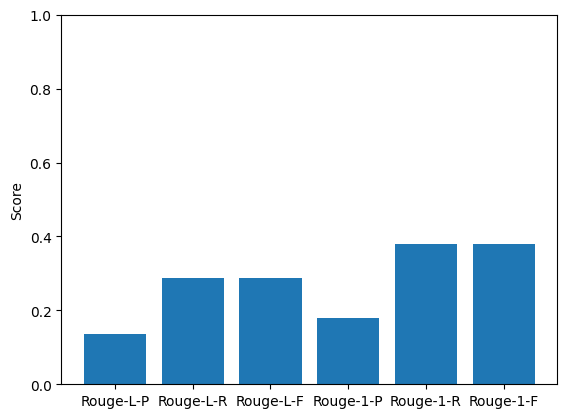

In [47]:
plot_data(data)

In [66]:
prompt4 = "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]"
data_zero_shot = evaluate_model(
        model3,
        test_loader,
        device="cuda",
        bert=False,
        tokenizer=tokenizer3,
        prompt=prompt4,
        promptsuff = "[AGENT]"
    )


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]The project at Ffrwd Farm Nature Reserve, Pembrey, is part of a wider ongoing water vole strategy for south Wales.
Natural Resources Wales said the creatures had suffered a huge decline in recent decades as a result of habitat loss, habitat fragmentation and predation by American mink.
It is the second release of water voles in the area.[AGENT]


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: The project at Ffrwd Farm Nature Reserve, Pembrey, is part of a wider ongoing water vole strategy fo
Prediction: A new release of water voles has been made in a Welsh village. The voles were originally released in 2010. They were initially released in a bid to restore the voles' numbers in the area. The project is part
Target: Water voles are being reintroduced at a Carmarthenshire nature reserve.
[['a', 'new', 'release', 'of', 'water', 'voles', 'has', 'been', 'made', 'in', 'a', 'welsh', 'village', 'the', 'voles', 'were', 'originally', 'released', 'in', '2010', 'they', 'were', 'initially', 'released', 'in', 'a', 'bid', 'to', 'restore', 'the', 'voles', 'numbers', 'in', 'the', 'area', 'the', 'project', 'is', 'part'], ['a', 'bonus', 'bond', 'winner', 'in', 'new', 'zealand', 'has', 'been', 'announced', 'by', 'the', 'country', 's', 'financial', 'regulator', 'it', 'is', 'the', 'largest', 'bonus', 'bond', 'in', 'history', 'the', 'winner', 'of', '300', '000', '230', '000', 'was', 'a', '1'

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: Matt McKeown from Plymouth, south-west England, has created a super trolley with a motor and special
Prediction: A super-trolley has been created by a 23-year-old student in Plymouth, England. It's a 10ft (3.07m) long motorised trolley with special wheels. It's set to go 4
Target: Imagine a shopping trolley that moves as fast as a car - well here it is!
[['a', 'super', 'trolley', 'has', 'been', 'created', 'by', 'a', '23', 'year', 'old', 'student', 'in', 'plymouth', 'england', 'it', 's', 'a', '10ft', '3', '07m', 'long', 'motorised', 'trolley', 'with', 'special', 'wheels', 'it', 's', 'set', 'to', 'go', '4'], ['former', 'dolphins', 'running', 'back', 'don', 'konrad', 'has', 'swum', 'more', 'than', '100', 'miles', '160', 'km', 'in', 'the', 'atlantic', 'ocean', 'he', 'swam', 'the', 'equivalent', 'of', '290', 'lengths', 'of', 'an', 'olympic', 'size', 'swimming', 'pool', 'konrad', 'swam'], ['two', 'men', 'have', 'been', 'arrested', 'in', 'connection', 'with', 'an', 'attempted', 'terror',

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: The 32-year-old had been playing in the Isthmian Premier Division with Leatherhead following his rel
Prediction: Forest Green Rovers have signed midfielder Jamie Pidgeley on a three-year deal after he was released by Newport County. The 2014 England Under-20 international made 260 appearances for the club. He will also play
Target: National League side Forest Green Rovers have signed goalkeeper Lenny Pidgeley until the end of the season.
[['forest', 'green', 'rovers', 'have', 'signed', 'midfielder', 'jamie', 'pidgeley', 'on', 'a', 'three', 'year', 'deal', 'after', 'he', 'was', 'released', 'by', 'newport', 'county', 'the', '2014', 'england', 'under', '20', 'international', 'made', '260', 'appearances', 'for', 'the', 'club', 'he', 'will', 'also', 'play'], ['mansfield', 'city', 'have', 'signed', 'shrewsbury', 'town', 'midfielder', 'tyler', 'caton', 'on', 'loan', 'until', 'the', 'end', 'of', 'the', 'season', 'the', 'former', 'accrington', 'stanley', 'player', 'has', 'signed', 'a', 'co

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: Police were called to Honeywell Drive, in Stepps, just after 21:00 on Sunday.
The man is said to be 
Prediction: A 21-year-old man has been arrested on suspicion of attempted murder after a man was found with stab wounds in a car in Swansea. He was treated in hospital and is in a stable condition. Police have appealed for witnesses. Two men have
Target: A 42-year-old man is being treated in hospital after being shot in a targeted attack near Glasgow.
[['a', '21', 'year', 'old', 'man', 'has', 'been', 'arrested', 'on', 'suspicion', 'of', 'attempted', 'murder', 'after', 'a', 'man', 'was', 'found', 'with', 'stab', 'wounds', 'in', 'a', 'car', 'in', 'swansea', 'he', 'was', 'treated', 'in', 'hospital', 'and', 'is', 'in', 'a', 'stable', 'condition', 'police', 'have', 'appealed', 'for', 'witnesses', 'two', 'men', 'have'], ['a', 'man', 'has', 'been', 'arrested', 'on', 'suspicion', 'of', 'terrorism', 'offences', 'after', 'a', 'suspected', 'bomb', 'was', 'found', 'in', 'a', 'house', 'in', 'gr

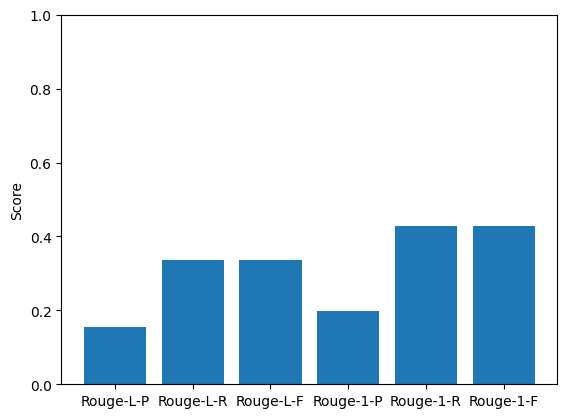

In [51]:
plot_data(data_zero_shot)

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
from peft import PeftModel
model_path = './drive/MyDrive/models/ft'
ft_model = PeftModel.from_pretrained(model3, model_path)


In [43]:
data_ft = evaluate_model(ft_model, test_loader, 'cuda', bert=False, tokenizer = tokenizer3, prompt = "[USER] Summarize this text: [TEXT]", promptsuff = "[AGENT]")

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


[USER] Summarize this text: [TEXT]27 August 2016 Last updated at 12:34 BST
The restaurant began serving puppy platters after a new law was introduced allowing dogs to eat at restaurants -  as long as they were outdoors!
It looks like a right dog's dinner - check out this clip.[AGENT]


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: 27 August 2016 Last updated at 12:34 BST
The restaurant began serving puppy platters after a new law
Prediction: A dog's menu is now being served at a restaurant in Liverpool, UK. They are serving a dog's meal made from dog food and treats. The restaurant says it was inspired by a famous dog's meal in the US. The dog's meal
Target: A restaurant in New York has a special menu for pampered pooches to eat alongside their owners.
[['a', 'dog', 's', 'menu', 'is', 'now', 'being', 'served', 'at', 'a', 'restaurant', 'in', 'liverpool', 'uk', 'they', 'are', 'serving', 'a', 'dog', 's', 'meal', 'made', 'from', 'dog', 'food', 'and', 'treats', 'the', 'restaurant', 'says', 'it', 'was', 'inspired', 'by', 'a', 'famous', 'dog', 's', 'meal', 'in', 'the', 'us', 'the', 'dog', 's', 'meal'], ['welsh', 'side', 'scarlets', 'are', 'the', 'only', 'team', 'in', 'the', 'anglo', 'welsh', 'cup', 'to', 'have', 'not', 'reached', 'the', 'semi', 'finals', 'cardiff', 'and', 'exeter', 'are', 'the', 'only', 'clubs', '

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: Media playback is unsupported on your device
7 May 2013 Last updated at 18:47 BST
It is a particular
Prediction: The problem of sleep deprivation in children and teenagers has been found to be widespread in the US, the study suggests. The study found the number of sleep-deprived students was 28% higher in the US than in the UK. The study
Target: Sleep deprivation is a significant hidden factor in lowering the achievement of school pupils, according to researchers carrying out international education tests.
[['the', 'problem', 'of', 'sleep', 'deprivation', 'in', 'children', 'and', 'teenagers', 'has', 'been', 'found', 'to', 'be', 'widespread', 'in', 'the', 'us', 'the', 'study', 'suggests', 'the', 'study', 'found', 'the', 'number', 'of', 'sleep', 'deprived', 'students', 'was', '28', 'higher', 'in', 'the', 'us', 'than', 'in', 'the', 'uk', 'the', 'study'], ['a', 'new', 'exhibition', 'at', 'a', 'welsh', 'castle', 'has', 'been', 'launched', 'to', 'mark', 'the', '100th', 'anniversary', 'o

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: Edward Furneaux, 74, died after crashing his car into a tree in Kewstoke Road, Worle, on the morning
Prediction: A murder inquiry has been launched after the body of an elderly woman was found in a house in Wiltshire. Her husband, who died a short time later, was also found dead in the same property. The two deaths are not connected, police
Target: A husband and wife who died in an apparent murder-suicide in North Somerset have been named.
[['a', 'murder', 'inquiry', 'has', 'been', 'launched', 'after', 'the', 'body', 'of', 'an', 'elderly', 'woman', 'was', 'found', 'in', 'a', 'house', 'in', 'wiltshire', 'her', 'husband', 'who', 'died', 'a', 'short', 'time', 'later', 'was', 'also', 'found', 'dead', 'in', 'the', 'same', 'property', 'the', 'two', 'deaths', 'are', 'not', 'connected', 'police'], ['two', 'men', 'have', 'been', 'arrested', 'in', 'connection', 'with', 'allegations', 'of', 'child', 'sexual', 'exploitation', 'in', 'rotherham', 'one', 'of', 'the', 'men', 'is', 'from', 'south'

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: Sannah Javid, 26, of Frank Slater House, Green Lane, Ilford, was taken to King George Hospital on Tu
Prediction: A woman who was stabbed to death at her flat in north London has been named as a 27-year-old woman. Her death is being treated as murder by the Met Police. A 37-year-old man has been arrested on suspicion of
Target: A 37-year-old man has been arrested on suspicion of murder after a woman who was found in her east London flat with serious injuries died.
[['a', 'woman', 'who', 'was', 'stabbed', 'to', 'death', 'at', 'her', 'flat', 'in', 'north', 'london', 'has', 'been', 'named', 'as', 'a', '27', 'year', 'old', 'woman', 'her', 'death', 'is', 'being', 'treated', 'as', 'murder', 'by', 'the', 'met', 'police', 'a', '37', 'year', 'old', 'man', 'has', 'been', 'arrested', 'on', 'suspicion', 'of'], ['scotland', 'won', 'their', 'first', 'european', 'championship', 'title', 'in', '12', 'years', 'with', 'victory', 'over', 'sweden', 'in', 'stockholm', 'the', 'win', 'sees', 'them', 'lea

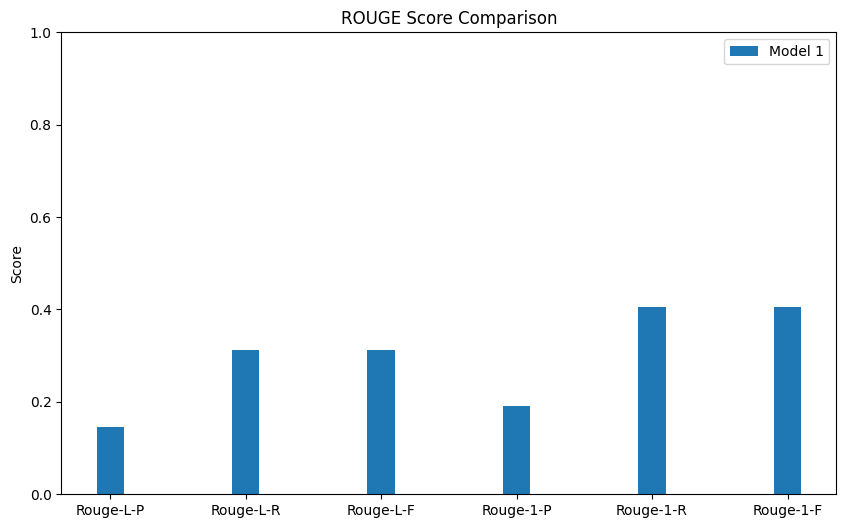

[0.1454608  0.31294537 0.31294537 0.19038456 0.40494488 0.40494488]
[0.14031207 0.29666536 0.29666536 0.18972935 0.39808566 0.39808566]


In [67]:
plot_data([data_zero_shot])
print(data_zero_shot)
print(data_ft)